<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/14_rl/03_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的
Actor Criticの仕組みを理解し，ゲームタスクを用いて強化学習をおこなう．\
学習後のエージェントの可視化を行い，学習がうまくできているか確認をおこなう．

# Actor Critic
Actor Criticは強化学習における1手法で，推定した状態価値をもとに報酬をより多く得るように方策を更新するActorと，方策に対する状態価値を推定するCriticという2つの学習器を同時学習する手法です．Actor-Critic法は，ActorとCriticと呼ばれる独立した学習器をそれぞれ学習します．Actorは行動の確率分布から自身の方策により行動を選択します．Criticでは，計算したTD誤差に応じて確率分布を更新し，の状態価値関数$V(s)$を最適状態価値関数になるように更新します．また,これらの更新は独立して行われます．DCNN を用いたActor Critic の手法では,ActorとCriticをそれぞれニューラルネットワークを用いて表現し，方策を改善するActorと状態価値を出力し方策の評価を行うCriticは同時に学習をおこないます．2つの学習器を用いて評価するため，学習の安定化を図ることができる手法です．派生手法には，DDPG，A3C，UNREALなどがあります．\
<img src="http://drive.google.com/uc?export=view&id=1AHF4pDprrPBS7YExTcUhi2R5ZOCAzdZn" width = 40%>

## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではPyTorchを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


### モジュールの追加インストール
下記のプログラムを実行して，実験結果の表示に必要な追加ライブラリやモジュールをインストールする．

In [ ]:
!apt-get -qq -y install libcusparse9.1 libnvrtc9.1 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.9.1 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null

!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

## モジュールのインポート
Actor Criticで利用するモジュールをインポートします．

In [ ]:
import numpy as np
import gym

import time
import math
import random
import numpy as np
import collections
import cv2
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# 使用するデバイス（GPU or CPU）の決定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use device:", device)

Use device: cuda


### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`Use CUDA: True`と表示されれば，GPUを使用した計算をPyTorchで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

## OpenAI GymによるPongの環境の定義
 [OpenAI Gym](https://github.com/openai/gym) は，様々な種類の環境を提供しているモジュールです．
 
 今回はgymで利用できるatariゲームであるPongを実行します．
 まず，gym.make関数で実行したい環境を指定します．
 その後，reset関数を実行することで，環境を初期化します．
 
Pong環境は，パドルを操作してボールが自分の陣地に入らないように打ち返すゲームです．Pong環境において現在の状態を確認するためにゲームの画面情報が与えられており，`observation_space`という変数で確認することができます．
また，`action_space`という変数で，エージェントが取ることのできる行動の数を確認することができます．
Pongの場合は，パドルを上下どちらかに移動させるという行動を取るため，行動の数は2となっています．
Pongのゲーム概要は，相手の陣地にボールを入れることで得点を獲得し，ボールを自分の陣地に入れられることで得点を取られます．どちらかのプレイヤーが21点取った時点で終了となります．



In [ ]:
# 環境の指定
env = gym.make('PongNoFrameskip-v0')

# 環境の初期化
obs = env.reset()
#env.render()
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('initial observation:', obs)

# 行動の決定と決定した行動の入力
action = env.action_space.sample()
obs, r, done, info = env.step(action)
print('next observation:', obs)
print('reward:', r)
print('done:', done)
print('info:', info)

observation space: Box(0, 255, (210, 160, 3), uint8)
action space: Discrete(6)
initial observation: [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 ...

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]

 [[ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]
  ...
  [ 53  95  24]
  [ 53  95  24]
  [ 53  95  24]]]
next observation: [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  43]
  ...
  [109 118  43]
  [109 118  43]
  [109 118  43]]

 [[109 118  43]
  [109 118  43]
  [109 118  

## ネットワーク構造
Actor-Criticのネットワークを定義します．畳み込み層が3層と，そこから全結合層2層のブランチを2つで構成されるネットワークをActor-Criticのネットワークとします．それぞれのブランチをPolicy branchとValue branchとしていて，それぞれ出力が異なります．Policy branchのネットワークからはエージェントの行動に対する確率を出力し，Value branchのネットワークからは状態価値を出力します．入力はgymのatari環境から得たゲーム画面を入力としています．

入力データのサイズをinput_shape，出力する行動の数をn_actionsとし，ネットワークの作成時に変更できるようにしておきます．

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ActorCritic, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.policy = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        fx = x.float() / 256
        conv_out = self.conv(fx).view(fx.size()[0], -1)
        return self.value(conv_out), self.policy(conv_out)

## Lossの計算
Actor-CriticのLoss計算はそれぞれ独立しておこないます．Valueでは最適状態価値を出力するように学習を行います．Loss計算は，次状態の推定の価値と実際に起こした行動から得られる価値の差を0にするように状態価値関数$V$を更新していくTD誤差を用いて更新します．ここで，$r$は報酬値で$\gamma$は割引率です．\
\
$$
L_{v}=(r+{\gamma}V(s_{t+1})-V(s_t))^2
$$
\
Policyでは，最適な行動の確率を上げるように学習を行います．Loss計算にはValueの結果を利用します．$A(s)$は次状態の推定の価値と実際に起こした行動から得られる価値の差であり，Valueでの更新で使用したLossと同じです．方策$\pi$のLossにそのまま用います．ここで，$H$はエントロピーであり，$\beta$はエントロピーの正則化項です．

また，$A(s)$の計算でValueの出力を使用しているため，勾配が流れてしまわないように注意して下さい．\
\
$$
A(s)=(r+{\gamma}V(s_{t+1})-V(s_t))^2 \\
$$
$$
L_p=-log(\pi(a|s))A(s)-\beta H(\pi)
$$
\
Lossの計算を行う関数を定義します．calc_loss関数ではPolicyとValueの両方のLossを計算します．

In [ ]:
def calc_loss(agent, R, device):
    policy_loss = 0
    value_loss = 0

    for i in reversed(range(len(agent.rewards))):
      R = 0.99 * R + agent.rewards[i]
      advantage = R - agent.values[i]
      value_loss = value_loss + 0.5 * advantage.pow(2)

      policy_ad = advantage.detach()

      policy_loss = policy_loss - agent.log_probs[i] * policy_ad - 0.01 * agent.entropies[i]
    
    return policy_loss, value_loss

## その他の学習に必要な処理
gymのatari環境で学習の安定化と効率的な学習を行うための処理をいくつか行います．

In [ ]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        """For environments where the user need to press FIRE for the game to start."""
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer

### 学習に必要な処理の適用
環境に対して必要となるそれぞれの処理を作成した環境に対して適用します．

In [ ]:
env = MaxAndSkipEnv(env)
env = FireResetEnv(env)
env = ProcessFrame84(env)
env = ImageToPyTorch(env)
env = BufferWrapper(env, 4)
env = ScaledFloatFrame(env)

## エージェントの定義
エージェントが環境に対して確率で行動し，経験をそれぞれ収集します．

train時のエージェントの行動を定義します．action_train関数では，受け取った環境情報をネットワークに入力し，行動の確率と状態価値を受け取ります．行動の確率をもとに行動を決定します．

In [ ]:
class Agent(object):
    def __init__(self, model, env, state, device):
        self.model = model
        self.env = env
        self.state = state
        self.eps_len = 0
        self.values = []
        self.log_probs = []
        self.rewards = []
        self.entropies = []
        self.done = True
        self.info = None
        self.reward = 0
        self.device = device

    def action_train(self):
        value, logit = self.model(self.state.unsqueeze(0))
        prob = F.softmax(logit, dim=1)
        log_prob = F.log_softmax(logit, dim=1)
        entropy = -(log_prob * prob).sum(1)
        self.entropies.append(entropy)
        action = prob.multinomial(1).detach()
        log_prob = log_prob.gather(1, action)
        state, self.reward, self.done, self.info = self.env.step(action.cpu().numpy())
        in_state = state
        self.state = torch.from_numpy(in_state).to(device).float()
        self.reward = max(min(self.reward, 1), -1)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.rewards.append(self.reward)
        return self

    def clear_actions(self):
        self.values = []
        self.log_probs = []
        self.rewards = []
        self.entropies = []
        return self

## 学習
Actor Criticを用いて学習を行います．学習環境はatari環境のPongゲーム環境を用います．学習回数を100万step(frame)分とし，環境の終了条件はどちらかが21点とったら終了としています．また，最適化にはRMSPropを利用します．学習には時間がかかるため時間がない人はこちらで学習した学習済みモデルを使ってもらいます．

In [ ]:
episode = 200 
device = 'cuda:0'
num_steps = 20
LR = 0.0001
frame_idx = 0
num_frame = 10000000
reward = 0
rewards = []
ts = time.time()
ts_frame = 0
best_mean_reward = None

state = env.reset()
state = torch.from_numpy(state).to(device).float()
acnet = ActorCritic(env.observation_space.shape, env.action_space.n).to(device)
optimizer = optim.RMSprop(acnet.parameters(), lr = LR)
agent = Agent(acnet, env, state, device)
agent.model.train()

while frame_idx < num_frame:
  for step in range(num_steps):
    agent.action_train()
    reward += agent.reward
    frame_idx += 1
    if agent.done:
      break
  if agent.done:
    state = agent.env.reset()
    agent.state = torch.from_numpy(state).to(device).float()
    rewards.append(reward)
    speed = (frame_idx - ts_frame) / (time.time() - ts)
    ts_frame = frame_idx
    ts = time.time()
    mean_reward = np.mean(rewards[-100:])
    print("%d: done %d games, mean reward %.3f, speed %.2f f/s" % (
        frame_idx, len(rewards), mean_reward, speed))
    if best_mean_reward is None or best_mean_reward < mean_reward:
        torch.save(acnet.state_dict(), "Pong" + "-best.dat")
        if best_mean_reward is not None:
            print("Best mean reward updated %.3f -> %.3f, model saved" % (best_mean_reward, mean_reward))
        best_mean_reward = mean_reward
    reward = 0


  R = torch.zeros(1, 1, device=device)
  if not agent.done:
    value, _ = agent.model(agent.state.unsqueeze(0))
    R = value.detach()

  agent.values.append(R)
  
  policy_loss, value_loss = calc_loss(agent, R, device)
  agent.model.zero_grad()
  (policy_loss + 0.5 * value_loss).backward()
  optimizer.step()
  
  agent.clear_actions()

850: done 1 games, mean reward -21.000, speed 238.90 f/s
1672: done 2 games, mean reward -21.000, speed 237.47 f/s
2800: done 3 games, mean reward -20.333, speed 238.39 f/s
Best mean reward updated -21.000 -> -20.333, model saved
3651: done 4 games, mean reward -20.500, speed 237.21 f/s
4672: done 5 games, mean reward -20.200, speed 239.06 f/s
Best mean reward updated -20.333 -> -20.200, model saved
5743: done 6 games, mean reward -20.333, speed 237.26 f/s
6738: done 7 games, mean reward -20.143, speed 239.14 f/s
Best mean reward updated -20.200 -> -20.143, model saved
7691: done 8 games, mean reward -20.125, speed 236.29 f/s
Best mean reward updated -20.143 -> -20.125, model saved
8648: done 9 games, mean reward -20.222, speed 239.93 f/s
9548: done 10 games, mean reward -20.200, speed 239.12 f/s
10433: done 11 games, mean reward -20.182, speed 238.20 f/s
11641: done 12 games, mean reward -20.250, speed 241.21 f/s
12586: done 13 games, mean reward -20.231, speed 239.78 f/s
13382: done 

KeyboardInterrupt: ignored

## 評価
学習したネットワーク（エージェント）を確認してみます．

ここでは，framesに描画したフレームを順次格納します．

In [ ]:
# 結果を描画するための設定
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display._obj._screen)


frames = []
for i in range(3):
    state = env.reset()
    agent.state = torch.from_numpy(state).to(device).float()
    done = False
    R = 0
    t = 0
    
    while not done and t < 200:
        frames.append(env.render(mode='rgb_array'))
        with torch.no_grad():  
          value, logit = agent.model(agent.state.unsqueeze(0))
        prob = F.softmax(logit, dim=1)
        action = prob.max(1)[1].detach().cpu().numpy()
        state, r, done, _ = env.step(action)
        R += r
        t += 1
    print("test episode:", i, "R:", R)

test episode: 0 R: -4.0
test episode: 1 R: -4.0
test episode: 2 R: -4.0


## 描画

maptlotlibを用いて，保存した動画フレームをアニメーションとして作成し，表示しています．

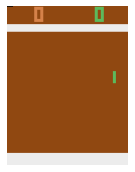

In [ ]:
# 実行結果の表示
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

## 課題